# Reading and Writing Audio Files with wave

[back to overview page](index.ipynb)

The `wave` module is part of the Python standard library.

Documentation:

* http://docs.python.org/2/library/wave.html (Python 2.x)
* http://docs.python.org/3/library/wave.html (Python 3.x)

Audio data is handled with the Python type `str` (Python 2.x) or `bytes` (Python 3.x).

Advantages:

* part of the standard library, no further dependencies
* 24-bit files can be used (but manual conversion is necessary)
* partial reading is possible
* works with both Python 2 and 3

Disadvantages:

* 32-bit float not supported
* WAVEX doesn't work
* manual de-interleaving and conversion is necessary

## Reading

Reading a 16-bit WAV file into a NumPy array is not hard, but it requires a few lines of code:

In [1]:
import wave
import numpy as np
import utility

with wave.open('data/test_wav_pcm16.wav') as w:
    channels = w.getnchannels()
    assert w.getsampwidth() == 2
    data = w.readframes(w.getnframes())

sig = np.frombuffer(data, dtype='<i2').reshape(-1, channels)

normalized = utility.pcm2float(sig, np.float32)

But not so fast! Let's do that step-by-step and put a few explanations in between.

First, let's load matplotlib and NumPy and enable inline plotting:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

The most important module we need to load is the built-in `wave` module.

In [3]:
import wave

Now we open a 16-bit WAV file, show a few informations and read its contents.

Note: starting from Python 3.4, [wave.open()](https://docs.python.org/3/library/wave.html#wave.open)
returns a context manager which can be used in a ["with" statement](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement).
For Python < 3.4, you should wrap the `open()` call with [contextlib.closing()](https://docs.python.org/3/library/contextlib.html#contextlib.closing).

In [4]:
with wave.open('data/test_wav_pcm16.wav') as w:
    framerate = w.getframerate()
    frames = w.getnframes()
    channels = w.getnchannels()
    width = w.getsampwidth()
    print('sampling rate:', framerate, 'Hz')
    print('length:', frames, 'samples')
    print('channels:', channels)
    print('sample width:', width, 'bytes')
    
    data = w.readframes(frames)

sampling rate: 44100 Hz
length: 15 samples
channels: 7
sample width: 2 bytes


We see that the *sample width* is 2 bytes, which we expected for a 16-bit file.

If the audio file has 7 channels, is 15 samples long and uses 2 bytes (16 bit) per sample, the buffer has a size of $7 \times 15 \times 2 = 210$ bytes.

In [5]:
len(data)

210

Audio data is stored in "strings of bytes".
In Python 2 this type is called `str`, in Python 3 it's called `bytes` (which makes much more sense, doesn't it?).

In [6]:
type(data)

bytes

The buffer data looks like this (which isn't really helpful because it looks like garbage):

In [7]:
data

b'\xff\x7f\xb6mm[$I\xdb6\x92$I\x12RsgDX\x14\xba\xef\xcc\xdd\r\xdf\xb7\xed\xceO\x96\xe7\xa1\xad\x1a\xbe\xcb\xf3\xcd\x16I\x12{\x1c\'\x9d\xff\xc6\x9a-l1\xdd\xf7\xb7\xed\x85\xe3\'\x9d\x019\x9a-\x94\xce\xdd\xf7I\x122\xb0\x96\xe7_R\x1a\xbe5\x0c\xcd\x16\xb7\xed\xae\x8cgD\xa8\xeb\xba\xef4"\r\xdfI\x12\x01\x80\xb6m\x93\xa4$I%\xc9\x92$\xb7\xed\xae\x8cgD\xa8\xeb\xba\xef4"\r\xdfI\x122\xb0\x96\xe7_R\x1a\xbe5\x0c\xcd\x16\xb7\xed\x85\xe3\'\x9d\x019\x9a-\x94\xce\xdd\xf7I\x12{\x1c\'\x9d\xff\xc6\x9a-l1\xdd\xf7\xb7\xed\xceO\x96\xe7\xa1\xad\x1a\xbe\xcb\xf3\xcd\x16I\x12RsgDX\x14\xba\xef\xcc\xdd\r\xdf\xb7\xed\xff\x7f\xb6mm[$I\xdb6\x92$I\x12'

We could convert the bytes by means of the [`struct` module](https://docs.python.org/3/library/struct.html), but it's easier with [the `frombuffer()` function from NumPy](http://docs.scipy.org/doc/numpy/reference/generated/numpy.frombuffer.html).
We have to specify (similar to how it's done in the `struct` module) how the bytes should be interpreted to yield the desired numbers.

If we would interpret them as single (unsigned) bytes, it would look like this (still not very useful):

In [8]:
np.frombuffer(data, dtype='B')

array([255, 127, 182, 109, 109,  91,  36,  73, 219,  54, 146,  36,  73,
        18,  82, 115, 103,  68,  88,  20, 186, 239, 204, 221,  13, 223,
       183, 237, 206,  79, 150, 231, 161, 173,  26, 190, 203, 243, 205,
        22,  73,  18, 123,  28,  39, 157, 255, 198, 154,  45, 108,  49,
       221, 247, 183, 237, 133, 227,  39, 157,   1,  57, 154,  45, 148,
       206, 221, 247,  73,  18,  50, 176, 150, 231,  95,  82,  26, 190,
        53,  12, 205,  22, 183, 237, 174, 140, 103,  68, 168, 235, 186,
       239,  52,  34,  13, 223,  73,  18,   1, 128, 182, 109, 147, 164,
        36,  73,  37, 201, 146,  36, 183, 237, 174, 140, 103,  68, 168,
       235, 186, 239,  52,  34,  13, 223,  73,  18,  50, 176, 150, 231,
        95,  82,  26, 190,  53,  12, 205,  22, 183, 237, 133, 227,  39,
       157,   1,  57, 154,  45, 148, 206, 221, 247,  73,  18, 123,  28,
        39, 157, 255, 198, 154,  45, 108,  49, 221, 247, 183, 237, 206,
        79, 150, 231, 161, 173,  26, 190, 203, 243, 205,  22,  7

To be able to do something useful with the data, we have to take pairs of 2 bytes and convert them to 16-bit integers. Thereby we have to consider that data in WAV files is stored in *little endian* format (the least significant byte comes first and then the most significant byte), which is specified with `'<'` in the format string.

Let's also reshape the array to get a column for each channel:

In [9]:
sig = np.frombuffer(data, dtype='<i2').reshape(-1, channels)
sig

array([[ 32767,  28086,  23405,  18724,  14043,   9362,   4681],
       [ 29522,  17511,   5208,  -4166,  -8756,  -8435,  -4681],
       [ 20430,  -6250, -21087, -16870,  -3125,   5837,   4681],
       [  7291, -25305, -14593,  11674,  12652,  -2083,  -4681],
       [ -7291, -25305,  14593,  11674, -12652,  -2083,   4681],
       [-20430,  -6250,  21087, -16870,   3125,   5837,  -4681],
       [-29522,  17511,  -5208,  -4166,   8756,  -8435,   4681],
       [-32767,  28086, -23405,  18724, -14043,   9362,  -4681],
       [-29522,  17511,  -5208,  -4166,   8756,  -8435,   4681],
       [-20430,  -6250,  21087, -16870,   3125,   5837,  -4681],
       [ -7291, -25305,  14593,  11674, -12652,  -2083,   4681],
       [  7291, -25305, -14593,  11674,  12652,  -2083,  -4681],
       [ 20430,  -6250, -21087, -16870,  -3125,   5837,   4681],
       [ 29522,  17511,   5208,  -4166,  -8756,  -8435,  -4681],
       [ 32767,  28086,  23405,  18724,  14043,   9362,   4681]],
      dtype=int16)

Let's see how this look like:

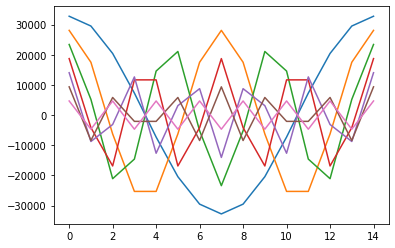

In [10]:
plt.plot(sig);

Note that neither `frombuffer()` nor `reshape()` made a copy of the data. We are still using the buffer of bytes we got from `readframes()`. By using the `.base` attribute of the array we get the result of `frombuffer()` (before `reshape()`) and by using `.base` a second time, we get a reference to the original buffer object:

In [11]:
sig.base.base is data

True

With the `flags` attribute we get a few details about the buffer. `C_CONTIGUOUS` means that the rows are contiguous (in row-major format, like it's used in C). We also see that `sig` doesn't "own" the data (it's rather "borrowed" from the `data` object) and that it's not writable (because the `bytes` object returned by `readframes()` above happens to be read-only):

In [12]:
sig.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

We've already got the correct values but if we want to do some signal processing with the data, it's normally easier to convert the numers to floating point format and to normalize them to a range from -1 to 1.

To do that, I wrote a little helper function called `utility.pcm2float()`, located in the file [utility.py](https://github.com/mgeier/python-audio/blob/master/audio-files/utility.py), let's load it and apply it to our signal:

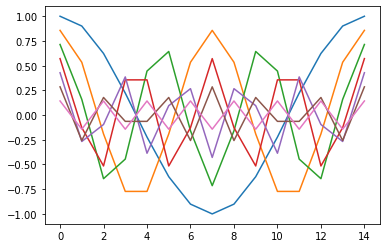

In [13]:
import utility

normalized = utility.pcm2float(sig, 'float32')

plt.plot(normalized);

Because we change the data type from int16 to float32, a copy of the array is created, which now is writable and "owns" its data:

In [14]:
normalized.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

24-bit files can be opened with `wave.open()` as well, but the conversion is a little more complicated.

In [15]:
with wave.open('data/test_wav_pcm24.wav') as w:
    framerate = w.getframerate()
    frames = w.getnframes()
    channels = w.getnchannels()
    width = w.getsampwidth()
    print('sampling rate:', framerate, 'Hz')
    print('length:', frames, 'samples')
    print('channels:', channels)
    print('sample width:', width, 'bytes')
    
    data = w.readframes(frames)

sampling rate: 44100 Hz
length: 15 samples
channels: 7
sample width: 3 bytes


Note that the sample width is 3 bytes (because we loaded a 24-bit file). Sadly, there is no 3-byte integer type in NumPy. Therefore, we have to fill each 3-byte number with a further byte and then convert it to a 4-byte integer.
We can add this byte (filled with zero-bits) either as most significant or a least significant byte. This doesn't change the precision of the data, we just have to remember which one it was when we do calculations with the stored values.
If we add the zero-byte as LSB, the resulting values will have the full range of a 4-byte integer, therefore we can use the `utility.pcm2float()` function from above.
If we would add the zero-byte as MSB, the range would be limited to a 3-byte integer and we would have to write a new function for normalization.

In [16]:
assert width == 3

temp = bytearray()

for i in range(0, len(data), 3):
    temp.append(0)
    temp.extend(data[i:i+3])

# Using += instead of .extend() may be faster
# (see https://youtu.be/z9Hmys8ojno?t=35m50s).
# But starting with an empty bytearray and
# extending it on each iteration might be slow, anyway.
# See further below for how to reserve all necessary memory in the beginning.

four_bytes = np.frombuffer(temp, dtype='B').reshape(-1, 4)
four_bytes

array([[  0, 255, 255, 127],
       [  0, 219, 182, 109],
       [  0, 182, 109,  91],
       [  0, 146,  36,  73],
       [  0, 109, 219,  54],
       [  0,  73, 146,  36],
       [  0,  36,  73,  18],
       [  0, 242,  82, 115],
       [  0, 222, 103,  68],
       [  0,  67,  88,  20],
       [  0, 100, 185, 239],
       [  0,  17, 204, 221],
       [  0, 223,  12, 223],
       [  0, 220, 182, 237],
       [  0, 131, 206,  79],
       [  0,  22, 150, 231],
       [  0,  47, 160, 173],
       [  0, 191,  25, 190],
       [  0,  11, 203, 243],
       [  0,  74, 205,  22],
       [  0,  36,  73,  18],
       [  0, 145, 123,  28],
       [  0, 158,  38, 157],
       [  0, 199, 254, 198],
       [  0, 148, 154,  45],
       [  0, 177, 108,  49],
       [  0, 178, 220, 247],
       [  0, 220, 182, 237],
       [  0, 111, 132, 227],
       [  0, 158,  38, 157],
       [  0,  57,   1,  57],
       [  0, 148, 154,  45],
       [  0,  79, 147, 206],
       [  0, 178, 220, 247],
       [  0,  

Now we have a bytearray where each group of 4 bytes represents an integer (in little-endian order).

Next, let's convert it to actual integers and reshape the channels into columns.

In [17]:
sig = np.frombuffer(temp, dtype='<i4').reshape(-1, channels)
sig

array([[ 2147483392,  1840700160,  1533916672,  1227133440,   920349952,
          613566720,   306783232],
       [ 1934815744,  1147657728,   341328640,  -273062912,  -573828864,
         -552804608,  -306783232],
       [ 1338934016,  -409594368, -1382011136, -1105608960,  -204797184,
          382552576,   306783232],
       [  477860096, -1658413568,  -956381440,   765105152,   829206784,
         -136531456,  -306783232],
       [ -477860096, -1658413568,   956381440,   765105152,  -829206784,
         -136531456,   306783232],
       [-1338934016,  -409594368,  1382011136, -1105608960,   204797184,
          382552576,  -306783232],
       [-1934815744,  1147657728,  -341328640,  -273062912,   573828864,
         -552804608,   306783232],
       [-2147483392,  1840700160, -1533916672,  1227133440,  -920349952,
          613566720,  -306783232],
       [-1934815744,  1147657728,  -341328640,  -273062912,   573828864,
         -552804608,   306783232],
       [-1338934016,  -40959

Let's put this into a function, just in case we find ourselves needing to load 24-bit WAV files some time in the future.

In [18]:
def pcm24to32_bytearray(data, channels=1):
    if len(data) % 3 != 0:
        raise ValueError('Size of data must be a multiple of 3 bytes')

    size = len(data) // 3
    
    # reserve memory (initialized with null bytes):
    temp = bytearray(size * 4)

    for i in range(size):
        newidx = i * 4 + 1
        oldidx = i * 3
        temp[newidx:newidx+3] = data[oldidx:oldidx+3]

    return np.frombuffer(temp, dtype='<i4').reshape(-1, channels)

This looks a bit clumsy (*TODO:* timing measurements!), let's try it another way:

In [19]:
def pcm24to32_view(data, channels=1):
    if len(data) % 3 != 0:
        raise ValueError('Size of data must be a multiple of 3 bytes')

    temp = np.zeros((len(data) // 3, 4), dtype='B')
    temp[:, 1:] = np.frombuffer(data, dtype='B').reshape(-1, 3)
    return temp.view('<i4').reshape(-1, channels)

This is what we're doing here:
* create a zero-initialized array of bytes with 4 columns
* write the data to the last 3 columns (leaving the first column filled with zeros)
* interpret each row (4 bytes) as one integer

I think this is better than `pcm24to32_bytearray()`, but it still has a little flaw: the returned array doesn't own it's data.

In [20]:
sig = pcm24to32_view(data, channels)
sig.flags.owndata

False

This is because a *view* is returned. The original array (with its 4 columns) has exactly the same values as the array `four_bytes` which we were using before.

In [21]:
np.all(sig.base == four_bytes)

True

So instead of returning a view, let's turn this around and create the correct array first and use a view internally to copy the data.
Additionally, instead of using the `reshape()` method (which would also return a view), we directly set the shape.

In [22]:
def pcm24to32(data, channels=1):
    if len(data) % 3 != 0:
        raise ValueError('Size of data must be a multiple of 3 bytes')
    
    out = np.zeros(len(data) // 3, dtype='<i4')
    out.shape = -1, channels
    temp = out.view('B').reshape(-1, 4)
    temp[:, 1:] = np.frombuffer(data, dtype='B').reshape(-1, 3)
    return out

I think this one is better.

Now the returned array owns its data:

In [23]:
sig = pcm24to32(data, channels)
sig.flags.owndata

True

I added this implementation (plus a little tweak) to [utility.py](utility.py).
Let's have a look at the documentation:

In [24]:
help(utility.pcm24to32)

Help on function pcm24to32 in module utility:

pcm24to32(data, channels=1, normalize=True)
    Convert 24-bit PCM data to 32-bit.
    
    Parameters
    ----------
    data : buffer
        A buffer object where each group of 3 bytes represents one
        little-endian 24-bit value.
    channels : int, optional
        Number of channels, by default 1.
    normalize : bool, optional
        If ``True`` (the default) the additional zero-byte is added as
        least significant byte, effectively multiplying each value by
        256, which leads to the maximum 24-bit value being mapped to the
        maximum 32-bit value.  If ``False``, the zero-byte is added as
        most significant byte and the values are not changed.
    
    Returns
    -------
    numpy.ndarray
        The content of *data* converted to an *int32* array, where each
        value was padded with zero-bits in the least significant byte
        (``normalize=True``) or in the most significant byte
        (``norm

As you can see, I added the function argument `normalize`, which allows to select if the zero-byte shall be added as LSB or MSB.
The default behavior is unchanged, though.

In [25]:
sig = utility.pcm24to32(data, channels)

BTW, the result of all three implementations is of course the same:

In [26]:
np.all(sig == pcm24to32_view(data, channels)), np.all(sig == pcm24to32_bytearray(data, channels))

(True, True)

Finally, we convert the 32-bit integer values to 32-bit floating point values and normalize them to a range from -1 to 1 (see above).

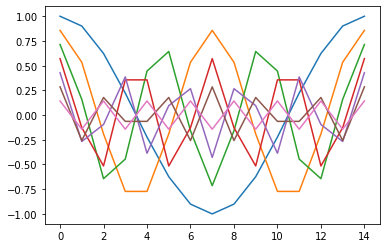

In [27]:
normalized = utility.pcm2float(sig, 'float32')
plt.plot(normalized);

WAVEX doesn't work:

In [28]:
import traceback
try:
    w = wave.open('data/test_wavex_pcm16.wav')
except:
    traceback.print_exc()
else:
    print('It works (unexpectedly)!')

Traceback (most recent call last):
  File "<ipython-input-28-1129b9db34db>", line 3, in <module>
    w = wave.open('data/test_wavex_pcm16.wav')
  File "/usr/lib/python3.7/wave.py", line 510, in open
    return Wave_read(f)
  File "/usr/lib/python3.7/wave.py", line 164, in __init__
    self.initfp(f)
  File "/usr/lib/python3.7/wave.py", line 144, in initfp
    self._read_fmt_chunk(chunk)
  File "/usr/lib/python3.7/wave.py", line 269, in _read_fmt_chunk
    raise Error('unknown format: %r' % (wFormatTag,))
wave.Error: unknown format: 65534


Let's try 32-bit float:

In [29]:
try:
    w = wave.open('data/test_wav_float32.wav')
except:
    traceback.print_exc()
else:
    print('It works (unexpectedly)!')

Traceback (most recent call last):
  File "<ipython-input-29-4e786c43cf07>", line 2, in <module>
    w = wave.open('data/test_wav_float32.wav')
  File "/usr/lib/python3.7/wave.py", line 510, in open
    return Wave_read(f)
  File "/usr/lib/python3.7/wave.py", line 164, in __init__
    self.initfp(f)
  File "/usr/lib/python3.7/wave.py", line 144, in initfp
    self._read_fmt_chunk(chunk)
  File "/usr/lib/python3.7/wave.py", line 269, in _read_fmt_chunk
    raise Error('unknown format: %r' % (wFormatTag,))
wave.Error: unknown format: 3


## Writing

TODO

Another way (without NumPy): http://soledadpenades.com/2009/10/29/fastest-way-to-generate-wav-files-in-python-using-the-wave-module/

Another way for 24-bit WAV files (with NumPy): https://github.com/WarrenWeckesser/wavio

## Version Info

In [30]:
import sys, IPython
print('Versions: NumPy = {}; IPython = {}'.format(np.__version__, IPython.__version__))

print('Python interpreter:')
print(sys.version)

Versions: NumPy = 1.16.2; IPython = 7.5.0.dev
Python interpreter:
3.7.4 (default, Jul 11 2019, 10:43:21) 
[GCC 8.3.0]


<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>